In [264]:
import pandas as pd
import numpy as np
import collections

from datetime import datetime, timedelta 

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

from pycaret.regression import *
from sklearn.model_selection import TimeSeriesSplit
import xgboost

In [241]:
train = pd.read_csv('../input/train.csv')
train.head()

,id,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,...,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,thumbnail_url,zipcode,y
0,0,6,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",2.0,Real Bed,1.0,4.0,flexible,LA,t,...,-118.154761,The Penthouse,NaN,1,Apartment,60.0,Private room,NaN,90804,138.0
1,1,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,strict,DC,t,...,-76.978190,Guest Bedroom in Brookland,Brookland,9,House,100.0,Private room,https://a0.muscache.com/im/pictures/e4d8b51f-6...,20018,42.0
2,2,2,"{TV,Internet,""Wireless Internet"",Kitchen,""Indo...",2.0,Real Bed,1.0,1.0,strict,NYC,t,...,-73.926240,Clean Modern Room in Lux Apt 1 Block From J Train,Bushwick,27,Apartment,83.0,Private room,https://a0.muscache.com/im/pictures/5ffecc9b-d...,NaN,65.0
3,3,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,strict,SF,t,...,-122.411906,BEST views + reviews! 5/5 stars*****,Nob Hill,38,Apartment,95.0,Private room,NaN,94133,166.0
4,4,2,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.0,Real Bed,1.0,1.0,strict,NYC,t,...,-73.974691,Charming 1-bedroom - UWS Manhattan,Upper West Side,5,Apartment,100.0,Entire home/apt,https://a0.muscache.com/im/pictures/92879730/5...,10024,165.0


In [242]:
temp = train['amenities'].apply(lambda x : x.strip('{|}').replace('"','').replace(' ','_').replace('/','_').split(","))

In [243]:
temp

0        [TV, Wireless_Internet, Kitchen, Free_parking_...
1        [TV, Cable_TV, Internet, Wireless_Internet, Ai...
2        [TV, Internet, Wireless_Internet, Kitchen, Ind...
3        [TV, Cable_TV, Internet, Wireless_Internet, Ai...
4        [TV, Internet, Wireless_Internet, Air_conditio...
                               ...                        
55578    [TV, Cable_TV, Internet, Wireless_Internet, Ai...
55579    [TV, Internet, Wireless_Internet, Air_conditio...
55580    [TV, Internet, Wireless_Internet, Kitchen, Hea...
55581    [TV, Wireless_Internet, Air_conditioning, Pool...
55582    [TV, Cable_TV, Internet, Wireless_Internet, Ai...
Name: amenities, Length: 55583, dtype: object

In [246]:
all_amenities = str()
for _, j in enumerate(temp):
    amenity = ','.join(j) + ','
    all_amenities = all_amenities + ','.join(amenity.split(',')) 

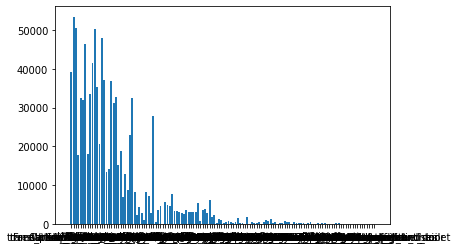

In [271]:
w = collections.Counter(all_amenities.split(','))
plt.bar(w.keys(), w.values())
plt.show()

In [272]:
w

Counter({'TV': 39316,
         'Wireless_Internet': 53440,
         'Kitchen': 50657,
         'Free_parking_on_premises': 17687,
         'Washer': 32359,
         'Dryer': 32047,
         'Smoke_detector': 46308,
         'Cable_TV': 18157,
         'Internet': 33518,
         'Air_conditioning': 41455,
         'Heating': 50328,
         'Carbon_monoxide_detector': 35385,
         'First_aid_kit': 20730,
         'Essentials': 47994,
         'Shampoo': 37037,
         'Lock_on_bedroom_door': 13374,
         '24-hour_check-in': 14240,
         'Hangers': 36957,
         'Iron': 31264,
         'Laptop_friendly_workspace': 32768,
         'translation_missing:_en.hosting_amenity_49': 15317,
         'translation_missing:_en.hosting_amenity_50': 18870,
         'Indoor_fireplace': 6966,
         'Buzzer_wireless_intercom': 12769,
         'Safety_card': 8672,
         'Fire_extinguisher': 22987,
         'Hair_dryer': 32458,
         'Self_Check-In': 8353,
         'Keypad': 2279,
   

In [40]:
train = train[[#'id', 
               'accommodates',
               'amenities', 
               'bathrooms', 
               'bed_type',
               'bedrooms',
               'beds', 
               'cancellation_policy', 
               'city',
               'cleaning_fee', 
               #'description',
               'first_review', 
               'host_has_profile_pic', 
               'host_identity_verified',
               #'host_response_rate',
               'host_since', 
               'instant_bookable', 
               'last_review',
               'latitude', 
               'longitude', 
               #'name', 
               #'neighbourhood',
               'number_of_reviews',
               'property_type', 
               'review_scores_rating', 
               'room_type', 
               #'thumbnail_url',
               #'zipcode',
               'y']]

In [41]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55583 entries, 0 to 55582
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   accommodates            55583 non-null  int64  
 1   amenities               55583 non-null  int64  
 2   bathrooms               55436 non-null  float64
 3   bed_type                55583 non-null  object 
 4   bedrooms                55512 non-null  float64
 5   beds                    55487 non-null  float64
 6   cancellation_policy     55583 non-null  object 
 7   city                    55583 non-null  object 
 8   cleaning_fee            55583 non-null  object 
 9   first_review            43675 non-null  object 
 10  host_has_profile_pic    55435 non-null  object 
 11  host_identity_verified  55435 non-null  object 
 12  host_since              55435 non-null  object 
 13  instant_bookable        55583 non-null  object 
 14  last_review             43703 non-null

In [8]:
# train[['cancellation_policy', 'city', 'bed_type', 'cleaning_fee', 'host_has_profile_pic',
#       'host_identity_verified', 'instant_bookable', 'zipcode']].apply(lambda x: x.value_counts())

In [42]:
train_train = train.iloc[:50000,:]
train_test = train.iloc[50000:,:]

In [43]:
test =  pd.read_csv('../input/test.csv')
test.head()

,id,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,thumbnail_url,zipcode
0,0,6,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",2.0,Real Bed,2.0,2.0,strict,Boston,t,Feel free to book INSTANTLY. You can check-in ...,2017-01-09,t,f,100%,2016-08-23,t,2017-09-25,42.359278,-71.069962,Gorgeous 2BR/2BA Duplex in Beacon Hill,Beacon Hill,58,House,90.0,Entire home/apt,https://a0.muscache.com/im/pictures/7e4808b4-5...,02114
1,1,3,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,moderate,LA,t,The guest house is close to: Equinox West Holl...,2016-08-17,t,t,100%,2014-09-03,f,2017-05-02,34.084747,-118.367355,Luxury 1 Bedroom West Hollywood City Center,West Hollywood,4,Guesthouse,100.0,Entire home/apt,https://a0.muscache.com/im/pictures/5392fbd6-6...,90046
2,2,2,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",1.0,Real Bed,0.0,1.0,flexible,NYC,f,Private room in a three bedroom apartment in N...,NaN,t,t,100%,2012-10-17,f,NaN,40.720541,-73.959192,Bedroom with Patio in Prime Williamsburg Locat...,Williamsburg,0,Apartment,NaN,Private room,https://a0.muscache.com/im/pictures/544d3b89-d...,11249.0
3,3,4,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,2.0,strict,NYC,f,The apartment is located in historic Bed Stuy ...,NaN,t,t,NaN,2013-01-23,f,NaN,40.681117,-73.944091,Cozy apartment in Brooklyn,Bedford-Stuyvesant,0,Apartment,NaN,Entire home/apt,https://a0.muscache.com/im/pictures/26baf7ba-0...,11216
4,4,3,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.5,Real Bed,1.0,2.0,strict,LA,t,"Our cozy, pet friendly one bedroom apartment/l...",2015-08-01,t,t,100%,2014-12-28,f,2016-09-11,34.150995,-118.409359,"Cozy, sunny, pet friendly loft/apt",NaN,6,Loft,92.0,Entire home/apt,https://a0.muscache.com/im/pictures/86107545/9...,91604


In [44]:
test =   test[[#'id', 
               'accommodates',
               'amenities', 
               'bathrooms', 
               'bed_type',
               'bedrooms',
               'beds', 
               'cancellation_policy', 
               'city',
               'cleaning_fee', 
               #'description',
               'first_review', 
               'host_has_profile_pic', 
               'host_identity_verified',
               #'host_response_rate',
               'host_since', 
               'instant_bookable', 
               'last_review',
               'latitude', 
               'longitude', 
               #'name', 
               #'neighbourhood',
               'number_of_reviews',
               'property_type', 
               'review_scores_rating', 
               'room_type'
               #'thumbnail_url',
               #'zipcode'
]]

In [50]:
test['amenities'] = test['amenities'].apply(lambda x:x.split()).apply(lambda x: len(x)) # 要素数カウント

In [45]:
# test['y'] = 0

In [46]:
exp1 = setup(data = train_train, 
             test_data = train_test,
             target = 'y', 
             # ignore_features = None, 
             fold_shuffle= True, 
             #fold_strategy = tscv ,#'timeseries',
             data_split_shuffle = True)     

,Description,Value
0,session_id,988
1,Target,y
2,Original Data,"(50000, 22)"
3,Missing Values,True
4,Numeric Features,6
5,Categorical Features,12
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(50000, 175)"


In [ ]:
#best = compare_models(['lightgbm'])

In [47]:
best = create_model("lightgbm")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,53.0625,11724.7981,108.2811,0.5626,0.4202,0.3724
1,53.3841,10663.5970,103.2647,0.5637,0.4207,0.3741
2,54.3345,11859.3687,108.9007,0.5864,0.4232,0.3740
3,53.5762,12404.0170,111.3733,0.5496,0.4299,0.3955
4,50.3105,10697.7064,103.4297,0.6035,0.4062,0.3506
5,52.8863,11019.8349,104.9754,0.5717,0.4277,0.3779
6,54.4519,12339.8633,111.0849,0.5964,0.4128,0.3683
7,53.8202,12803.0611,113.1506,0.5612,0.4205,0.3721
8,52.8315,11540.7189,107.4277,0.5827,0.4231,0.3738
9,54.1187,12807.2290,113.1690,0.6220,0.4218,0.3751


In [48]:
final_best = finalize_model(best)

In [51]:
prediction = predict_model(best, data=test)

In [59]:
prediction.iloc[[0,]

In [52]:
prediction.to_csv("../output/prediction_add_amenities.csv")